# **Import des bibliothèques nécessaires**

In [1]:
import shutil
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from pathlib import Path
import warnings

# Ignorer tous les avertissements
warnings.filterwarnings("ignore")

2024-07-14 23:41:20.894823: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 23:41:20.894916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 23:41:21.071709: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Copier les fichiers du répertoire Input vers le répertoire Working**

In [2]:
# Source directory
src_dir_test = "/kaggle/input/dogs-cats/test/test"
src_dir_train = "/kaggle/input/dogs-cats/train/train"

# Destination directory
dst_dir_test = "/kaggle/working/test"
dst_dir_train = "/kaggle/working/train"

# Remove the destination directory if it exists
if os.path.exists(dst_dir_test):
    shutil.rmtree(dst_dir_test)

if os.path.exists(dst_dir_train):
    shutil.rmtree(dst_dir_train)

# Copy the entire directory and its contents recursively
shutil.copytree(src_dir_test, dst_dir_test)
shutil.copytree(src_dir_train, dst_dir_train)

'/kaggle/working/train'

# **Afficher quelques exemples d'images de chats et de chiens**

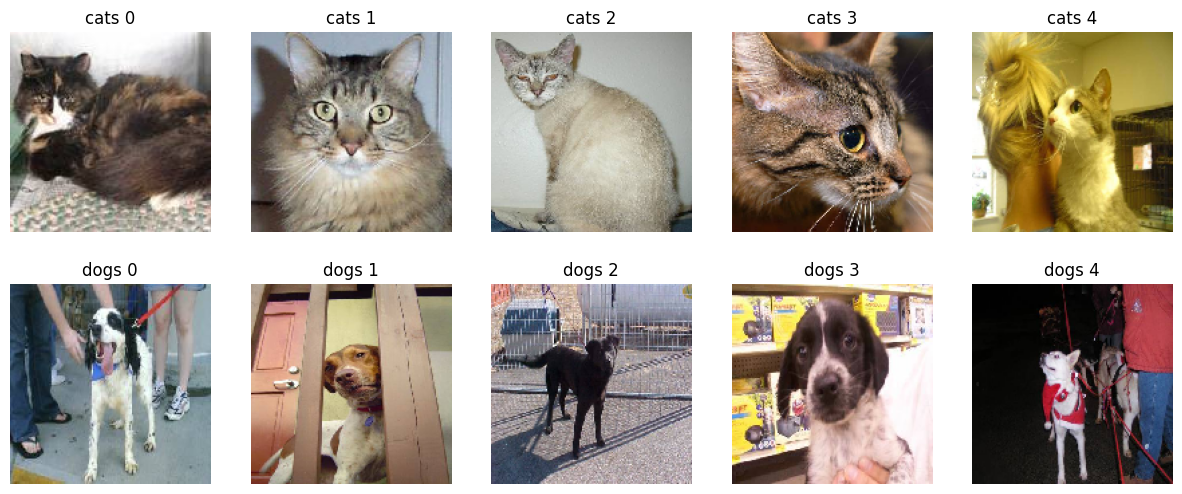

In [3]:
# Chemin des données
train_dir = '/kaggle/working/train'

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
categories = ['cats', 'dogs']
for i, category in enumerate(categories):
    category_path = os.path.join(train_dir, category)
    images = os.listdir(category_path)[:5]
    for j, img_name in enumerate(images):
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path, target_size=(150, 150))
        ax[i, j].imshow(img)
        ax[i, j].axis('off')
        ax[i, j].set_title(f"{category} {j}")
plt.show()

# **Training**

**Data Preprocessing**

In [4]:
def create_generators(train_dir, img_size=(150, 150), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.1)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training')

    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation')

    return train_generator, validation_generator

# Chemins des dossiers de données
train_dir = '/kaggle/working/train'

# Création des générateurs de données
train_generator, validation_generator = create_generators(train_dir)

# Affichage de quelques informations sur les générateurs
print(f"Nombre d'images dans le jeu d'entraînement : {train_generator.samples}")
print(f"Nombre d'images dans le jeu de validation : {validation_generator.samples}")

# Exemple d'utilisation des générateurs pour récupérer un lot d'images
batch_images, batch_labels = next(train_generator)
print(f"Shape du batch d'images : {batch_images.shape}")
print(f"Shape du batch de labels : {batch_labels.shape}")

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Nombre d'images dans le jeu d'entraînement : 22500
Nombre d'images dans le jeu de validation : 2500
Shape du batch d'images : (32, 150, 150, 3)
Shape du batch de labels : (32,)


**Model**

In [5]:
# Définir la taille des lots pour l'entraînement
batch_size = 64 #32

# Utiliser MirroredStrategy pour le parallélisme multi-CPU
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Créer le modèle CNN
    def create_model(input_shape=(150, 150, 3)):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            MaxPooling2D(pool_size=(2, 2)),

            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),

            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),

            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        return model

    # Créer et compiler le modèle
    model = create_model()

    # Entraîner le modèle
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size
    )

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 209ms/step - accuracy: 0.5285 - loss: 0.7255 - val_accuracy: 0.5833 - val_loss: 0.6693
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 201ms/step - accuracy: 0.6067 - loss: 0.6627 - val_accuracy: 0.6202 - val_loss: 0.6541
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step - accuracy: 0.6249 - loss: 0.6257 - val_accuracy: 0.0000e+00 - val_loss: 0.7866
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 75s 209ms/step - accuracy: 0.6561 - loss: 0.6344 - val_accuracy: 0.7067 - val_loss: 0.5844
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 198ms/step - accuracy: 0.6917 - loss: 0.5892 - val_accuracy: 0.7147 - val_loss: 0.5506
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - accuracy: 0.7185 - loss: 0.4905 - val_accuracy: 1.0000 - val_loss: 0.0604
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 204ms/step - accuracy: 0.7120 - loss: 0.5657 - val_accuracy: 0.7388 - val_loss: 0.5331
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 198ms/step - accuracy: 0.7393 - loss:

**Sauvegarder le modèle**

In [6]:
# Directory to save the model
save_dir = '/kaggle/working/saved_models'

# Remove the directory if it exists
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)

# Create the directory
os.makedirs(save_dir)

# Assuming model is already created and trained
# Save the model
model.save(os.path.join(save_dir, 'model.h5'))

# **Prédictions**

In [7]:
# Load the saved model
model = load_model('/kaggle/working/saved_models/model.h5')

# Function to preprocess the image
def preprocess_image(img_path, img_size=(150, 150)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Function to make predictions
def make_prediction(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    return 'Dog' if prediction[0][0] > 0.5 else 'Cat'

# Get list of test images
test_dir = Path('/kaggle/working/test')
test = list(test_dir.glob('*.jpg'))

# Create a tf.data.Dataset from the image paths
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [150, 150])
    img = img / 255.0
    return img, path

test_ds = tf.data.Dataset.from_tensor_slices([str(p) for p in test])
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(32)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Make predictions in parallel
predictions = []
file_paths = []
for batch, paths in test_ds:
    batch_preds = model.predict(batch)
    batch_preds = ['Dog' if pred > 0.5 else 'Cat' for pred in batch_preds]
    predictions.extend(batch_preds)
    file_paths.extend(paths.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


I0000 00:00:1721003184.992042     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

# **Display the results**

                        FilePath Prediction
0  /kaggle/working/test/6453.jpg        Dog
1  /kaggle/working/test/5140.jpg        Dog
2  /kaggle/working/test/6687.jpg        Cat
3   /kaggle/working/test/203.jpg        Dog
4   /kaggle/working/test/381.jpg        Dog


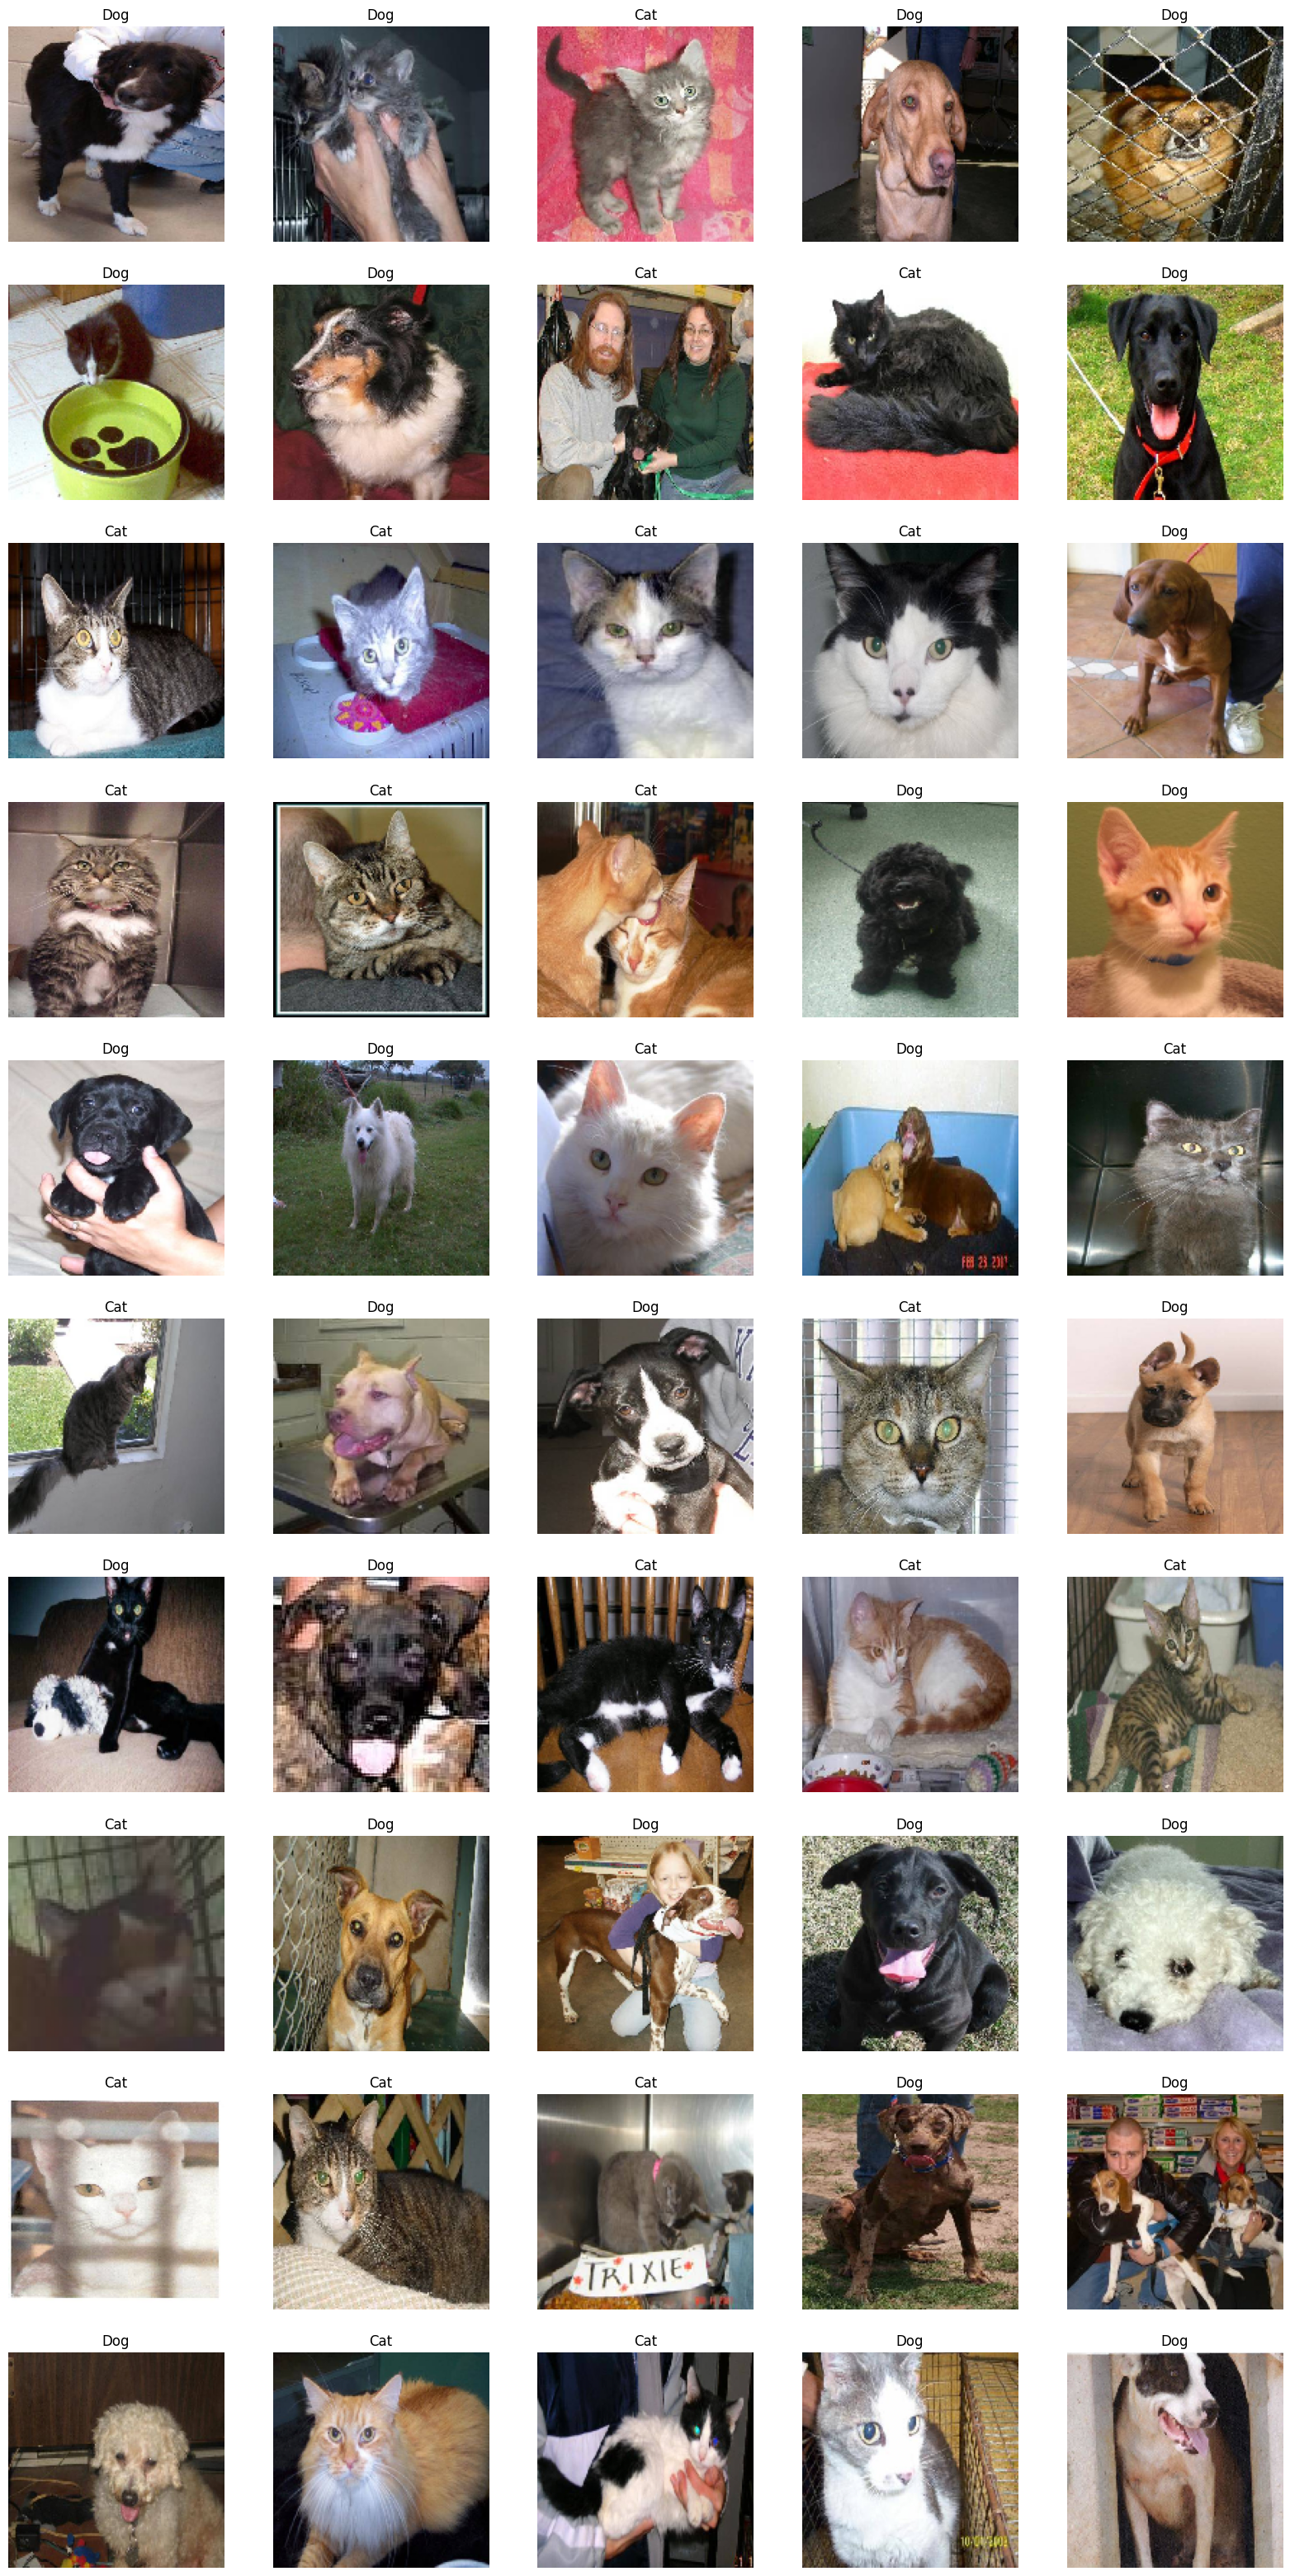

In [9]:
# Save results to a DataFrame
results_df = pd.DataFrame({'FilePath': [str(p, 'utf-8') for p in file_paths], 'Prediction': predictions})

# Display the results as a table
print(results_df.head())

# Display some images with their predictions
def display_images_with_predictions(df, num_images=50):
    import tensorflow.keras.preprocessing.image as image  # Import inside the function to ensure scope
    plt.figure(figsize=(20, 40))  # Adjust figure size as needed
    for i in range(num_images):
        img_path = df.iloc[i]['FilePath']
        prediction = df.iloc[i]['Prediction']
        img = image.load_img(img_path, target_size=(150, 150))
        plt.subplot(10, 5, i + 1)  # Adjust layout to 10 rows and 5 columns
        plt.imshow(img)
        plt.title(prediction)
        plt.axis('off')
    plt.show()

# Display the first 50 images with predictions
display_images_with_predictions(results_df, num_images=50)